
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Assignment 3 <br>
</div>


---



### Full Name : Raya Namazi
### Student Number : 402100561
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/DIP/Hw3-practical

/content/drive/MyDrive/DIP/Hw3-practical


In [ ]:
ls

lena.png  realImage.jpg


## Step 1: Divide image into 8x8 blocks and apply DCT
## (use realimage.jpg)

In [4]:
def apply_dct(image):

    h, w = image.shape
    new_h = h if h % 8 == 0 else h + (8 - h % 8)
    new_w = w if w % 8 == 0 else w + (8 - w % 8)
    padded_image = np.zeros((new_h, new_w), dtype=np.float64)
    padded_image[:h, :w] = image.astype(np.float64)

    blocks = padded_image.reshape(new_h//8, 8, new_w//8, 8).swapaxes(1, 2).reshape(-1, 8, 8)

    N = 8
    k = np.arange(N)[:, np.newaxis]
    n = np.arange(N)
    alpha = np.sqrt(2.0 / N) * np.ones((N, 1))
    alpha[0] = np.sqrt(1.0 / N)
    angles = (2 * n + 1) * k * np.pi / (2 * N)
    D = alpha * np.cos(angles)

    dct_blocks = np.array([D @ block @ D.T for block in blocks])

    return dct_blocks

## Step 2: Quantization


In [5]:
# Quantization matrix

Z = np.array([[16,11,10,16,24,40,51,61],
              [12,12,14,19,26,58,60,55],
              [14,13,16,24,40,57,69,56],
              [14,17,22,29,51,87,80,62],
              [18,22,37,56,68,109,103,77],
              [24,35,55,64,81,104,113,92],
              [49,64,78,87,103,121,120,101],
              [72,92,95,98,112,100,130,99]])

In [6]:
def quantize(dct_blocks):
    quantized_blocks = np.round(dct_blocks / Z).astype(np.int32)
    return quantized_blocks

### Matrix to vector
Now you need to convert the matrix to an array like this:

`[-17, 0, -19, ..., 'EOB']`

In [7]:
def mat_2_vec(jpeg_matrix):
    rows = 8
    cols = 8
    solution = [[] for _ in range(rows + cols - 1)]
    for i in range(rows):
        for j in range(cols):
            s = i + j
            if s % 2 == 0:
                solution[s].insert(0, (i, j))
            else:
                solution[s].append((i, j))
    zigzag_order = []
    for s in solution:
        zigzag_order.extend(s)

    rows_idx = np.array([i for i, j in zigzag_order])
    cols_idx = np.array([j for i, j in zigzag_order])

    jpeg_vector = []
    for block in jpeg_matrix:
        zigzag_values = block[rows_idx, cols_idx].tolist()
        zigzag_values.append('EOB')
        jpeg_vector.extend(zigzag_values)

    return jpeg_vector

## Step 3: Apply Inverse DCT for decompression

In [8]:
def apply_idct(quantized_blocks):

    dequantized_blocks = quantized_blocks.astype(np.float64) * Z

    N = 8
    k = np.arange(N)[:, np.newaxis]
    n = np.arange(N)
    alpha = np.sqrt(2.0 / N) * np.ones((N, 1))
    alpha[0] = np.sqrt(1.0 / N)
    angles = (2 * n + 1) * k * np.pi / (2 * N)
    D = alpha * np.cos(angles)

    idct_blocks = np.array([D.T @ block @ D for block in dequantized_blocks])

    num_blocks = idct_blocks.shape[0]

    block_rows = int(np.sqrt(num_blocks))
    while block_rows > 0 and num_blocks % block_rows != 0:
        block_rows -= 1
    if block_rows == 0:
        block_rows = 1
    block_cols = num_blocks // block_rows

    reshaped_blocks = idct_blocks.reshape(block_rows, block_cols, 8, 8)
    swapped_blocks = reshaped_blocks.swapaxes(1, 2)

    decompressed_image = swapped_blocks.reshape(block_rows * 8, block_cols * 8)

    return decompressed_image

In [9]:
import numpy as np

def vec_2_mat(jpeg_vector, original_shape):

    rows, cols = 8, 8
    solution = [[] for _ in range(rows + cols - 1)]
    for i in range(rows):
        for j in range(cols):
            s = i + j
            if s % 2 == 0:
                solution[s].insert(0, (i, j))
            else:
                solution[s].append((i, j))
    zigzag_order = []
    for s in solution:
        zigzag_order.extend(s)

    h, w = original_shape
    padded_h = h if h % 8 == 0 else h + (8 - h % 8)
    padded_w = w if w % 8 == 0 else w + (8 - w % 8)
    num_blocks_expected = (padded_h // 8) * (padded_w // 8)

    blocks_data = []
    current_block = []
    for elem in jpeg_vector:
        if elem == 'EOB':
            if current_block:
                blocks_data.append(current_block)
                current_block = []
                if len(blocks_data) == num_blocks_expected:
                    break
        else:
            current_block.append(elem)
    if current_block and len(blocks_data) < num_blocks_expected:
        blocks_data.append(current_block)

    jpeg_matrix = []
    for block_data in blocks_data:
        block = np.zeros((8, 8), dtype=np.int32)
        for idx, (i, j) in enumerate(zigzag_order):
            block[i, j] = block_data[idx]
        jpeg_matrix.append(block)

    return np.array(jpeg_matrix)

jpeg vector: [63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'EOB', 63, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'EOB', 64, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'EOB', 65, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'EOB', 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

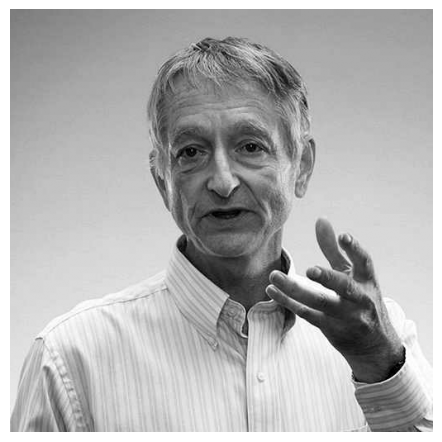

In [17]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

def compress_image_to_vector(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    dct_blocks = apply_dct(image)
    quantized_blocks = quantize(dct_blocks)


    jpeg_vector = mat_2_vec(quantized_blocks)

    return jpeg_vector, image.shape

def decompress_image_from_vector(jpeg_vector, original_shape):
    recovered_blocks = vec_2_mat(jpeg_vector, original_shape)

    decompressed_image = apply_idct(recovered_blocks)

    h, w = original_shape
    decompressed_image = decompressed_image[:h, :w]

    decompressed_image = np.clip(decompressed_image, 0, 255).astype(np.uint8)

    return decompressed_image

def calculate_metrics(original_image, decompressed_image, jpeg_vector):
    ssim_value = ssim(original_image, decompressed_image, data_range=255)
    psnr_value = psnr(original_image, decompressed_image, data_range=255)
    mse_value = mse(original_image, decompressed_image)

    original_size_bits = original_image.size * 8


    compressed_size_bits = len(jpeg_vector) * 16
    compression_ratio = original_size_bits / compressed_size_bits

    return {
        "SSIM": ssim_value,
        "PSNR": psnr_value,
        "MSE": mse_value,
        "Compression Ratio": compression_ratio
    }

if __name__ == "__main__":
    image_path = "realImage.jpg"

    jpeg_vector, original_shape = compress_image_to_vector(image_path)
    print("jpeg vector:", jpeg_vector)

    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (512, 512))
    decompressed_image = decompress_image_from_vector(jpeg_vector, original_shape)

    metrics = calculate_metrics(original_image, decompressed_image, jpeg_vector)

    print("\nmetrics:")
    print(f"SSIM: {metrics['SSIM']:.4f}")
    print(f"PSNR: {metrics['PSNR']:.2f} dB")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"compression ratio: {metrics['Compression Ratio']:.2f}")

    cv2.imwrite("decompressed_image.png", decompressed_image)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(decompressed_image, cmap='gray')
    plt.axis('off')
